<a href="https://colab.research.google.com/github/SamFC10/Barcode-Extractor/blob/master/Block_Pruning_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"samfc10","key":"2e702218bf5985237a63a77e6a0513de"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d chetankv/dogs-cats-images

dogs-cats-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import os
import zipfile

local_zip = '/content/dogs-cats-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import preprocess_input

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
train_gen = ImageDataGenerator(preprocessing_function = preprocess_input, width_shift_range=0.15,
                             height_shift_range=0.15, fill_mode='nearest', zoom_range=0.15 ,
                             horizontal_flip=True)
valid_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [8]:
train = train_gen.flow_from_directory('/content/dog vs cat/dataset/training_set', 
                                      target_size = (112,112), batch_size=64, color_mode='rgb', 
                                      class_mode="categorical", seed=1, shuffle=True)

valid = valid_gen.flow_from_directory('/content/dog vs cat/dataset/test_set', 
                                      target_size = (112,112), batch_size=64, color_mode='rgb',
                                      class_mode="categorical", seed=2)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
base_model = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(112,112,3))
for layer in base_model.layers:
    layer.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit_generator(train, steps_per_epoch = train.n//train.batch_size, 
                    validation_data=valid, validation_steps = valid.n//valid.batch_size, epochs=5)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
125/125 [==============================] - 59s 469ms/step - loss: 1.5309 - acc: 0.8443 - val_loss: 0.1617 - val_acc: 0.9471
Epoch 2/5
125/125 [==============================] - 57s 459ms/step - loss: 0.2249 - acc: 0.9043 - val_loss: 0.1587 - val_acc: 0.9509
Epoch 3/5
125/125 [==============================] - 56s 452ms/step - loss: 0.1858 - acc: 0.9231 - val_loss: 0.2174 - val_acc: 0.9437
Epoch 4/5
125/125 [==============================] - 57s 457ms/step - loss: 0.1909 - acc: 0.9191 - val_loss: 0.1634 - val_acc: 0.9504
Epoch 5/5
125/125 [==============================] - 58s 463ms/step - loss: 0.1751 - acc: 0.9284 - val_loss: 0.1666 - val_acc: 0.9483


In [12]:
%%time
print('Base accuracy : %.4f' %model.evaluate_generator(valid, steps = valid.n//valid.batch_size)[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Base accuracy : 0.9483
CPU times: user 8.1 s, sys: 278 ms, total: 8.38 s
Wall time: 7.06 s


In [0]:
end_index = [18, 28, 38, 50, 60, 70, 80, 92, 102, 112, 122, 132, 142, 154, 164, 174]
block_name = []
results = []

In [14]:
for end in end_index:
    base = tf.keras.models.Model(inputs = [model.input], outputs = [model.layers[end].output])
    for layer in base.layers:
        layer.trainable = False
    
    new_model = tf.keras.models.Sequential()
    new_model.add(base)
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    new_model.fit_generator(train, steps_per_epoch = train.n//train.batch_size, epochs=3, 
                            validation_data=valid, validation_steps = valid.n//valid.batch_size)
    
    print(model.layers[end].name[:12], 'accuracy = %.4f' %new_model.evaluate_generator(valid, 
                                                                                       steps = valid.n//valid.batch_size)[1])
    
    block_name.append(model.layers[end].name[:12])
    results.append(new_model.evaluate_generator(valid, steps = valid.n//valid.batch_size)[1])

Epoch 1/3
125/125 [==============================] - 55s 438ms/step - loss: 14.0536 - acc: 0.6315 - val_loss: 6.4000 - val_acc: 0.6111
Epoch 2/3
125/125 [==============================] - 51s 407ms/step - loss: 3.6380 - acc: 0.7036 - val_loss: 4.5220 - val_acc: 0.6767
Epoch 3/3
125/125 [==============================] - 51s 407ms/step - loss: 4.7347 - acc: 0.6880 - val_loss: 3.1238 - val_acc: 0.7660
conv2_block1 accuracy = 0.7769
Epoch 1/3
125/125 [==============================] - 55s 441ms/step - loss: 18.1172 - acc: 0.6385 - val_loss: 2.8730 - val_acc: 0.7696
Epoch 2/3
125/125 [==============================] - 52s 415ms/step - loss: 4.5277 - acc: 0.7170 - val_loss: 2.8660 - val_acc: 0.7670
Epoch 3/3
125/125 [==============================] - 52s 416ms/step - loss: 5.5335 - acc: 0.7014 - val_loss: 3.3678 - val_acc: 0.7738
conv2_block2 accuracy = 0.7691
Epoch 1/3
125/125 [==============================] - 56s 445ms/step - loss: 17.2984 - acc: 0.6593 - val_loss: 12.2732 - val_acc: 0.5

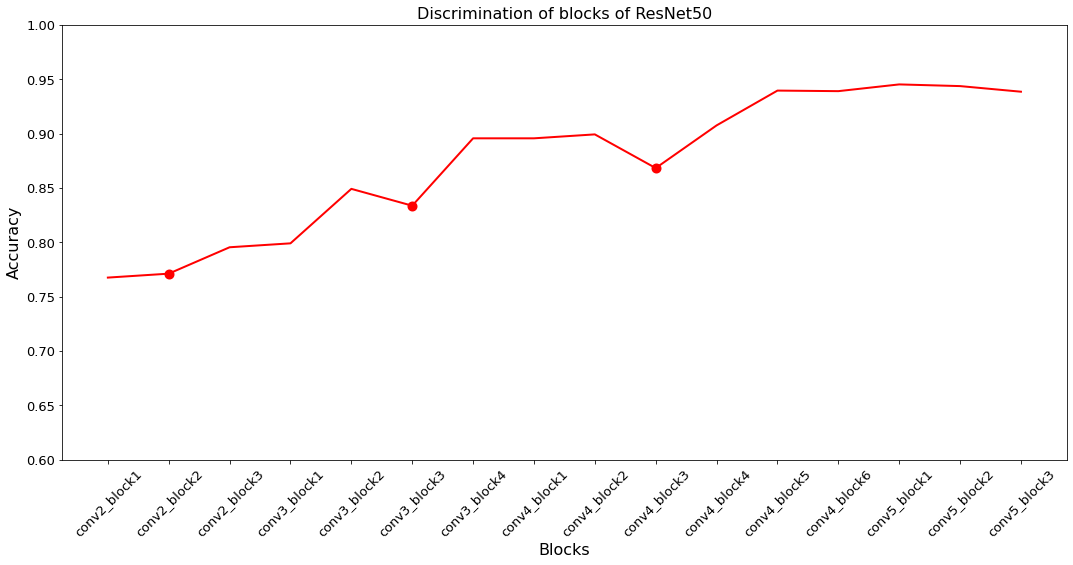

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))
markers_on = [1, 5, 9]
plt.plot(results, marker='o', color= 'r', markevery=markers_on, linewidth=2.0, mew=5, ms=5)
plt.xticks(range(0,16), labels=block_name, rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(0.6, 1.)
plt.xlabel('Blocks', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Discrimination of blocks of ResNet50', fontsize=16)
plt.show()